# Init

In [7]:
import pandas as pd
import numpy as np
import os
import warnings

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt

from scipy.interpolate import CubicSpline
from tqdm import tqdm, trange

# Suppress the SettingWithCopyWarning
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [2]:
def process_sensor_data(file_path, Hz = 50):
    # path = "/Users/alexanderithakis/Documents/GitHub/ML4QS/Python3Code/Data/Ezra/"

    Hz =50
    """
    This function processes sensor data from accelerometer, gyroscope, and linear accelerometer CSV files.

    Parameters:
    file_path (str): The path to the directory containing the CSV files. The directory should contain 'Accelerometer.csv', 'Gyroscope.csv', and 'Linear Accelerometer.csv'.

    Returns:
    df_interpolated (DataFrame): A DataFrame containing the interpolated sensor data. The DataFrame is indexed by time in seconds, and each column corresponds to a sensor reading.

    The function first reads the data from the CSV files and sets the time as the index. It then joins the data from the three files into a single DataFrame, sorting by time.
    The function then creates a new DataFrame to hold the interpolated data. It uses cubic spline interpolation to fill in any missing values in the sensor data.
    """

    accel = pd.read_csv(file_path+ "Accelerometer.csv").set_index("Time (s)")
    accel.columns = ["Accel X (m/s^2)", "Accel Y (m/s^2)", "Accel Z (m/s^2)"]
    gyro = pd.read_csv(file_path+ "Gyroscope.csv").set_index("Time (s)")
    gyro.columns = ["Gyro X (m/s^2)", "Gyro Y (m/s^2)", "Gyro Z (m/s^2)"]
    linear_accel = pd.read_csv(file_path+ "Linear Accelerometer.csv").set_index("Time (s)")
    linear_accel.columns = ["Lin Accel X (m/s^2)", "Lin Accel Y (m/s^2)", "Lin Accel Z (m/s^2)"]

    times = np.array(list(range(1, int(max(gyro.index.values)) * Hz))) / Hz

    df = accel.join(gyro, on="Time (s)", how="outer", rsuffix="_gyro").join(linear_accel, on="Time (s)", how="outer", rsuffix="_lin").set_index("Time (s)").sort_index()

    df_interpolated = pd.DataFrame(index=pd.Series(times, name="Time (s)"), columns=df.columns, data=np.zeros((times.shape[0], df.shape[1]))*np.nan)

    for col in df.columns:
        _values = df[col].values
        idx = np.isnan(_values)
        cs = CubicSpline(df.index.values[~idx], _values[~idx])
        df_interpolated[col] = cs(times)

    maxTime = 42 * 60 * Hz
    postureInterval = 2 * 60 * Hz
    transTime = 10  

    end_of_experiment_time = maxTime + transTime * Hz
    # Remove data after experiment is done
    df_interpolated = df_interpolated.iloc[df_interpolated.index.get_level_values(0) < (42*60 + 10)].sort_index()

    # Label order of experiment
    labelOrder          = ['L', 'R', 'L', 'F', 'L', 'B', 'L', 'S', 'R', 'F', 'R', 'B', 'R', 'S', 'F', 'B', 'F', 'S', 'B', 'S', 'L']
    labelOrderAlexander = ['L', 'R', 'L', 'F', 'L', 'B', 'L', 'S', 'R', 'F', 'B', 'B', 'R', 'S', 'F', 'B', 'F', 'S', 'B', 'S', 'L']

    # file_path
    if 'Alexander' in file_path: labelOrder = labelOrderAlexander
    # Set start times of transitions and labels, with 10 second time for transitions
    transPos = [i for i in range(0, len(df_interpolated), postureInterval)][:-1]
    labelPos = [time + transTime * Hz for time in transPos]

    transPos , len(df_interpolated)

    # Set labels
    labels = np.chararray(len(df_interpolated), unicode = True)
    for i, _times in enumerate(zip(transPos, labelPos)):
        # print(len(labels))
        labels[_times[0]:] = 'T'
        labels[_times[1]:] = labelOrder[i]
        
    df_interpolated["Label"] = labels

    return df_interpolated

In [3]:
# open the folder named Data and get the names of the files
path = "/Users/alexanderithakis/Documents/GitHub/ML4QS/Python3Code/Data/"
files = os.listdir(path)

dfs = []
for _file in tqdm(files):
    if _file[0] == '.': continue
    _df = process_sensor_data(path + _file + '/')
    # add to the _df a row with the name of the file which is going to be added to the index, so the index will have 2 levels
    _df = _df.assign(Participant = _file)
    _df = _df.set_index('Participant', append=True)

    position_time = (_df['Label'].iloc[0]  , _df.index.get_level_values('Time (s)').values[0])
    time_in_position = []
    for row in _df.iterrows():
        if row[1][9] == position_time[0]:
            time_in_position.append(row[0][0] -  position_time[1])
        else:
            time_in_position.append(0.0)
            position_time = (row[1][9]  , row[0][0] )
    
    _df['Time_in_position'] = time_in_position
    
    dfs.append(_df)
    # break

dfs = pd.concat(dfs)
dfs

,,Accel X (m/s^2),Accel Y (m/s^2),Accel Z (m/s^2),Gyro X (m/s^2),Gyro Y (m/s^2),Gyro Z (m/s^2),Lin Accel X (m/s^2),Lin Accel Y (m/s^2),Lin Accel Z (m/s^2),Label,Time_in_position
Time (s),Participant,,,,,,,,,,,
0.02,Ezra,-6.695648,6.425763,2.890562,-0.031204,0.219063,-0.027557,0.266295,0.195861,-0.270117,T,0.00
0.04,Ezra,-7.306077,6.184132,3.166081,-0.004081,0.102260,-0.025153,-0.405272,-0.160486,0.070983,T,0.02
0.06,Ezra,-7.165934,6.242556,3.196803,0.002151,0.016317,-0.007400,-0.393979,-0.133335,0.127672,T,0.04
0.08,Ezra,-7.057753,6.326050,3.187511,0.018974,-0.003981,0.014050,-0.248121,-0.018309,0.139324,T,0.06
0.10,Ezra,-6.914651,6.259296,3.146490,0.025652,0.005295,0.024584,-0.127193,-0.097493,0.100887,T,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...
2523.90,Sjors,-2.563917,9.418729,2.101827,0.013782,-0.060343,0.017629,-0.332171,0.134921,-0.077430,L,113.88
2523.92,Sjors,-2.239452,9.239055,2.222676,0.012139,-0.075650,-0.037158,0.014699,-0.027746,0.028434,L,113.90
2523.94,Sjors,-2.192481,9.256724,2.210018,0.011882,-0.050519,-0.067697,0.082193,-0.047331,0.027077,L,113.92


---------------------
# **Feature Engineering**

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.interpolate import CubicSpline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from scipy.signal import butter, filtfilt


class DataFrameStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.columns = None

    def fit(self, X, y=None):
        self.scaler.fit(X, y)
        self.columns = X.columns
        return self

    def transform(self, X, y=None):
        transformed_data = self.scaler.transform(X)
        return pd.DataFrame(transformed_data, columns=self.columns, index=X.index)

    
class LowpassFilterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cutoff=0.5, fs=1.0, order=5):
        self.cutoff = cutoff
        self.fs = fs
        self.order = order
    
    def lowpassFilter(self, data):
        nyq = 0.5 * self.fs
        normal_cutoff = self.cutoff / nyq
        b, a = butter(self.order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_filtered = X.copy()
        for column in X.columns:
            X_filtered[column + '_LP'] = self.lowpassFilter(X[column])
        return X_filtered


class LOFOutlierMarker(BaseEstimator, TransformerMixin):
    def __init__(self, algorithm='kd_tree', n_neighbors=20):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm 
    
    def fit(self, X, y=None):
        self.lof = LocalOutlierFactor(algorithm=self.algorithm, n_neighbors=self.n_neighbors, n_jobs=-1)
        return self
    
    def transform(self, X, y=None):
        X_marked = X.copy()
        outliers = self.lof.fit_predict(X_marked) == -1
        X_marked[outliers] = np.nan
        return X_marked


class CubicSplineInterpolator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_interpolated = X.copy()
 
        nan_idx = X_interpolated.isna().sum(axis=1).astype(bool).values
        times = X_interpolated.index.get_level_values(0)
        for column in X.columns:
            if len(nan_idx) > 0:
                cs = CubicSpline(times[~nan_idx], X_interpolated[column].iloc[~nan_idx])
                X_interpolated.loc[nan_idx, column] = cs(times[nan_idx])
        return X_interpolated


class ExponentialRollingFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, long_span=600, medium_span=100, short_span=25):
        self.long_span = long_span
        self.medium_span = medium_span
        self.short_span = short_span
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        new_columns = {}
        columns_to_transform = X.columns[:9]
        
        for column in columns_to_transform:
            new_columns[f'{column}_EMA_{self.long_span}'] = X[column].ewm(span=self.long_span).mean()
            new_columns[f'{column}_EMA_{self.medium_span}'] = X[column].ewm(span=self.medium_span).mean()
            new_columns[f'{column}_EMA_{self.short_span}'] = X[column].ewm(span=self.short_span).mean()
            new_columns[f'{column}_ESTD_{self.long_span}'] = X[column].ewm(span=self.long_span).std()
            new_columns[f'{column}_ESTD_{self.medium_span}'] = X[column].ewm(span=self.medium_span).std()
            new_columns[f'{column}_ESTD_{self.short_span}'] = X[column].ewm(span=self.short_span).std()
        
        X_rolling = pd.concat([X, pd.DataFrame(new_columns, index=X.index)], axis=1)
        return X_rolling.iloc[self.long_span*2:, :]


class LaggedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, long_span=600, medium_span=100, short_span=25):
        self.long_span = long_span
        self.medium_span = medium_span
        self.short_span = short_span

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        new_columns = {}
        for column in X.columns:
            new_columns[f'{column}_LAG_{self.long_span}'] = X[column].shift(self.long_span)
            new_columns[f'{column}_LAG_{self.medium_span}'] = X[column].shift(self.medium_span)
            new_columns[f'{column}_LAG_{self.short_span}'] = X[column].shift(self.short_span)
        
        X_lagged = pd.concat([X, pd.DataFrame(new_columns, index=X.index)], axis=1)
        return X_lagged

In [5]:
# Get Unique Participants 
participants = dfs.index.get_level_values(1).unique()

""" >> FLAML Pipeline ---------------------------------------------------------------- """
Flaml_pipeline = Pipeline([
    ('standard_scaler', DataFrameStandardScaler()),
    ('lowpass_filter', LowpassFilterTransformer(cutoff=0.0005, fs=1.0, order=1)),
    ('lof_marker', LOFOutlierMarker(algorithm='kd_tree', n_neighbors=50)),
    ('cubic_spline_interpolator', CubicSplineInterpolator()),
    ('exponential_rolling_features', ExponentialRollingFeatures(long_span=(2*120*50), medium_span=(30*50), short_span=(10*50))),
    ('lagged_features', LaggedFeatures(long_span=(2*120*50), medium_span=(30*50), short_span=(10*50)))
], verbose=True)

dfs2 = []
for participant in participants:
    data = dfs.query("Participant == @participant").copy(deep=True)
    data_pre_processed = Flaml_pipeline.fit_transform(X=data.drop(columns=["Label", "Time_in_position"]), y=data[["Label", "Time_in_position"]])
    data_pre_processed['Label'] = data['Label']
    data_pre_processed['Time_in_position'] = data['Time_in_position']
    # drop the rows which contain nan values
    data_pre_processed = data_pre_processed.dropna()
    dfs2.append(data_pre_processed)
    print('--------------------------------------------------------')

dfs2 = pd.concat(dfs2)


""" >> LSTM Pipeline ---------------------------------------------------------------- """
LSTM_pipeline = Pipeline([
    ('exponential_rolling_features', ExponentialRollingFeatures(long_span=(2*120*50), medium_span=(30*50), short_span=(10*50))),
], verbose=True)

dfs3 = []
for participant in participants:
    data = dfs.query("Participant == @participant").copy(deep=True)
    data_pre_processed = LSTM_pipeline.fit_transform(X=data.drop(columns=["Label", "Time_in_position"]), y=data[["Label", "Time_in_position"]])
    data_pre_processed['Label'] = data['Label']
    data_pre_processed['Time_in_position'] = data['Time_in_position']
    # drop the rows which contain nan values
    data_pre_processed = data_pre_processed.dropna()
    dfs3.append(data_pre_processed)

dfs3 = pd.concat(dfs3)

[Pipeline] ... (step 1 of 6) Processing standard_scaler, total=   0.0s
[Pipeline] .... (step 2 of 6) Processing lowpass_filter, total=   0.1s
[Pipeline] ........ (step 3 of 6) Processing lof_marker, total=  41.2s
[Pipeline]  (step 4 of 6) Processing cubic_spline_interpolator, total=   0.1s
[Pipeline]  (step 5 of 6) Processing exponential_rolling_features, total=   0.1s
[Pipeline] ... (step 6 of 6) Processing lagged_features, total=   0.1s
--------------------------------------------------------
[Pipeline] ... (step 1 of 6) Processing standard_scaler, total=   0.0s
[Pipeline] .... (step 2 of 6) Processing lowpass_filter, total=   0.0s
[Pipeline] ........ (step 3 of 6) Processing lof_marker, total=  30.9s
[Pipeline]  (step 4 of 6) Processing cubic_spline_interpolator, total=   0.1s
[Pipeline]  (step 5 of 6) Processing exponential_rolling_features, total=   0.1s
[Pipeline] ... (step 6 of 6) Processing lagged_features, total=   0.1s
--------------------------------------------------------


In [8]:
import gc
import sys

def create_sequences(data, tip, p, time_steps=8000, approx_number_of_samples = 10):
    # Make Linear Sampling for LSTM
    idx = np.linspace(1, time_steps, num=approx_number_of_samples, dtype=int)
    idx = (time_steps - idx)[::-1]

    X       = np.zeros((len(data) - time_steps, len(idx), data.shape[1]))
    _tip    = np.zeros((len(data) - time_steps, 1))
    _p      = np.chararray((len(data) - time_steps, 1), itemsize=1)
    for i in trange(len(data) - time_steps, desc='Creating Sequences', unit='sequence', leave=False):
        X[i]    = data[i:(i + time_steps)][idx]
        _tip[i] = tip[i + time_steps]
        _p[i]   = p[i + time_steps]
        
    return X, _tip, _p

# Prepare data for each participant without normalization
def prepare_participant_data(df, participant, time_steps=6000):
    df_participant  = df.query("Participant == @participant")
    features        = df_participant.drop(columns=['Label', 'Time_in_position']).values
    tip             = df_participant['Time_in_position'].values
    p               = df_participant['Label'].values
    idx             = df_participant.index.values
    X, tip, p = create_sequences(features, tip, p, time_steps)
    return X, tip, p, idx[time_steps:]

_data = dfs3.copy(deep=True)

time_steps = 8000 # 2 mins : 6000
X_E, tip_E, p_E, idx_E = prepare_participant_data(_data, 'Ezra', time_steps) ; gc.collect()
X_S, tip_S, p_S, idx_S = prepare_participant_data(_data, 'Sjors', time_steps) ; gc.collect()
X_A, tip_A, p_A, idx_A = prepare_participant_data(_data, 'Alexander', time_steps) ; gc.collect()

X_ES = np.concatenate([X_E, X_S], axis=0)
tip_ES = np.concatenate([tip_E, tip_S], axis=0)
p_ES = np.concatenate([p_E, p_S], axis=0)
idx_ES = np.concatenate([idx_E, idx_S], axis=0)

del X_E, X_S, tip_E, tip_S, p_E, p_S, idx_E, idx_S

print('\n'.join([f"Size of {name}: {sys.getsizeof(var) / (1024 * 1024):,.0f} MB" for name, var in [('X_ES', X_ES), ('X_A', X_A)]]))

# dfs2 = dfs2[(dfs2.index.isin(idx_ES) | dfs2.index.isin(idx_A))]

Size of X_ES: 907 MB
Size of X_A: 453 MB


----------------
# **Prediction - FLAML**

In [9]:
# Importing the necessary libraries for the task
from flaml import AutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [39]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import BaseCrossValidator
from flaml import AutoML
from sklearn.metrics import classification_report

class UniqueIdLeaveOneOutCV(BaseCrossValidator):
    def __init__(self, validation_column, n_splits=2):
        self.validation_column = validation_column
        self.n_splits = n_splits

    def split(self, X):
        _X = X.copy(deep=True).reset_index()
        unique_ids = np.unique(_X[self.validation_column])

        its = 0
        for val_id in unique_ids:
            if its == self.n_splits: break
            train_index = _X.index.values[(_X[self.validation_column] != val_id)]
            test_index  = _X.index.values[(_X[self.validation_column] == val_id)]

            yield train_index, test_index
            its += 1

    def get_n_splits(self):
        return self.n_splits

# Set this variable to True if you want to load the best configurations from the log file
load_from_log = True

log_file_name = 'flaml_logs.log'

# Initialize AutoML
automl = AutoML()

# Define the settings for FLAML
settings = {
    "time_budget": 40 * 60,  # time budget in seconds
    "estimator_list": ['lgbm', 'rf', 'extra_tree'],  # list of ML learners; we only use LGBM here
    "metric": 'rmse',  # primary metric to optimize
    "task": 'regression',  # type of task
    "log_file_name": log_file_name,  # flaml log file
    'log_type': 'all',
    "seed": 7654321,  # random seed
    'eval_method': 'cv',
    'split_type': UniqueIdLeaveOneOutCV(validation_column='Participant'),  # Use the custom CV here
    'skip_transform': True, # !! Keep False
    # 'retrain_full':True, # Re trains the estimator with the full data
}

# Train the model with the best configuration
_data = dfs2.copy(deep=True)  # with pre-processing

X = _data.drop(columns=['Label', 'Time_in_position'])
y = _data['Time_in_position']

# Keeping Alexander's data as test set
alexander_idx = X.index.get_level_values(1) == 'Alexander'

# Splitting data for training and test sets
X_train, X_test, y_train, y_test = X[~alexander_idx], X[alexander_idx], y[~alexander_idx], y[alexander_idx]

flaml_lstm_idx_intersection = np.intersect1d(y_test.index.values, idx_A)

X_test, y_test = X_test.loc[flaml_lstm_idx_intersection], y_test.loc[flaml_lstm_idx_intersection]
X_test

,,Accel X (m/s^2),Accel Y (m/s^2),Accel Z (m/s^2),Gyro X (m/s^2),Gyro Y (m/s^2),Gyro Z (m/s^2),Lin Accel X (m/s^2),Lin Accel Y (m/s^2),Lin Accel Z (m/s^2),Accel X (m/s^2)_LP,...,Lin Accel Z (m/s^2)_EMA_500_LAG_500,Lin Accel Z (m/s^2)_ESTD_12000_LAG_12000,Lin Accel Z (m/s^2)_ESTD_12000_LAG_1500,Lin Accel Z (m/s^2)_ESTD_12000_LAG_500,Lin Accel Z (m/s^2)_ESTD_1500_LAG_12000,Lin Accel Z (m/s^2)_ESTD_1500_LAG_1500,Lin Accel Z (m/s^2)_ESTD_1500_LAG_500,Lin Accel Z (m/s^2)_ESTD_500_LAG_12000,Lin Accel Z (m/s^2)_ESTD_500_LAG_1500,Lin Accel Z (m/s^2)_ESTD_500_LAG_500
Time (s),Participant,,,,,,,,,,,,,,,,,,,,,
720.02,Alexander,-1.676626,-2.734740,0.543153,0.051205,-0.089128,0.051594,-0.047250,0.039015,0.027664,-0.616194,...,0.045607,0.687098,1.199910,1.110783,0.342096,0.554644,0.387606,0.284096,0.432450,0.284832
720.04,Alexander,-1.668496,-2.776937,0.560976,0.002335,-0.039962,0.065045,0.007034,-0.200687,0.144613,-0.612946,...,0.044653,0.687059,1.199813,1.110693,0.342112,0.554311,0.387440,0.284371,0.431751,0.284663
720.06,Alexander,-1.680835,-2.797394,0.557276,0.018060,0.008929,-0.007998,-0.070587,-0.313730,0.126264,-0.609688,...,0.043497,0.687002,1.199721,1.110604,0.341891,0.554066,0.387318,0.283820,0.431407,0.284682
720.08,Alexander,-1.674246,-2.733446,0.553271,0.017111,0.022365,-0.037696,-0.033285,0.046531,0.101870,-0.606419,...,0.043686,0.686946,1.199628,1.110512,0.341730,0.553788,0.387065,0.283517,0.430931,0.284129
720.10,Alexander,-1.648037,-2.754548,0.559908,-0.032891,-0.054761,-0.027368,0.119158,-0.060960,0.150230,-0.603140,...,0.044724,0.686888,1.199533,1.110427,0.341511,0.553502,0.386930,0.282990,0.430418,0.284036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2524.90,Alexander,107.458177,-86.245404,-60.456371,65.976712,25.350811,201.366511,644.929793,-449.132026,-586.569284,-0.170113,...,0.022312,0.846640,0.668309,0.628040,1.112766,0.162859,0.270636,1.588735,0.118553,0.277536
2524.92,Alexander,123.508472,-98.977108,-69.657531,80.073733,30.258788,230.829860,741.376285,-515.397309,-674.257254,-0.169874,...,0.023112,0.846594,0.668255,0.627992,1.112156,0.162798,0.270529,1.585801,0.118511,0.277270
2524.94,Alexander,141.075869,-112.880752,-79.732311,95.805567,35.751214,262.995159,846.906252,-587.802868,-770.182406,-0.169623,...,0.022858,0.846620,0.668201,0.627940,1.111954,0.162734,0.270369,1.583688,0.118456,0.276745


In [40]:
from copy import deepcopy
Fresh = False
if Fresh :
    automl.fit(X_train=X_train, y_train=y_train.to_numpy(), **settings)
if not Fresh:
    settings_from_log = deepcopy(settings)
    del settings_from_log["metric"] ; del settings_from_log["estimator_list"] ; del settings_from_log["seed"] ; del settings_from_log["log_type"]#; del settings_from_log["ensemble"] # del settings_from_log["hpo_method"] ;
    automl.retrain_from_log(X_train=X_train, y_train=y_train.to_numpy(), **settings_from_log)

# Get predictions
tip_pred_flaml = automl.predict(X_test)

# Clean up
# del X_train, X_test, y_train, y_test


In [ ]:
# Get the best model for each estimator
estimator_performance = {}
for estimator_name in automl.best_config_per_estimator.keys():
    estimator = automl.best_model_for_estimator(estimator_name)
    estimator_performance[estimator_name] = {
        'best_config': automl.best_config_per_estimator[estimator_name],
        'best_loss': automl.best_loss_per_estimator[estimator_name],
        'best_iteration': automl.best_iteration,
    }

# Create a DataFrame to store the performance report
estimator_performance_df = pd.DataFrame(estimator_performance).T

# make a hbar plot with the performance of the estimators with matplotlib and sort them by the best_loss
estimator_performance_df = estimator_performance_df.sort_values(by='best_loss')
fig, ax = plt.subplots()
ax.barh(estimator_performance_df.index, estimator_performance_df['best_loss'])
ax.set_xlabel('RMSE')
ax.set_ylabel('Estimator')
ax.set_title('Estimator Performance - (less is better)')
plt.show()

----------------------
# **Temporal Deep Neural Network**

Epoch 1/50
738/738 [==============================] - 5s 6ms/step - loss: 2019.5027 - mae: 36.5459 - val_loss: 1164.9868 - val_mae: 29.4507
Epoch 2/50
738/738 [==============================] - 2s 3ms/step - loss: 830.6478 - mae: 22.7037 - val_loss: 759.4526 - val_mae: 20.1999
Epoch 3/50
738/738 [==============================] - 2s 3ms/step - loss: 370.2817 - mae: 12.3167 - val_loss: 807.0482 - val_mae: 18.6983
Epoch 4/50
738/738 [==============================] - 2s 3ms/step - loss: 260.3449 - mae: 9.7018 - val_loss: 750.6519 - val_mae: 17.8050
Epoch 5/50
738/738 [==============================] - 2s 3ms/step - loss: 221.8202 - mae: 8.8270 - val_loss: 795.4279 - val_mae: 17.8279
Epoch 6/50
738/738 [==============================] - 2s 3ms/step - loss: 202.6763 - mae: 8.2807 - val_loss: 757.7062 - val_mae: 17.3180
Epoch 7/50
738/738 [==============================] - 2s 3ms/step - loss: 190.7038 - mae: 7.9148 - val_loss: 793.5629 - val_mae: 18.7351
Epoch 8/50
738/738 [================

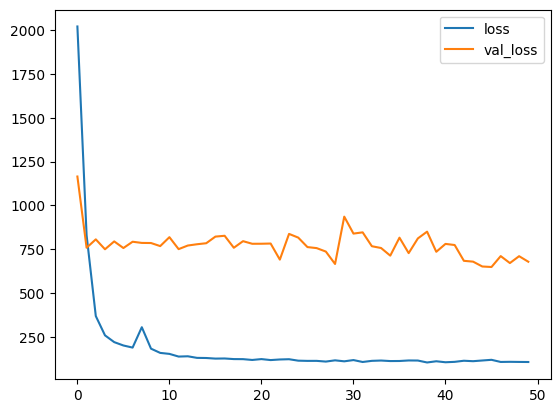

In [35]:
from tensorflow.random import set_seed

set_seed(0)

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.legacy import Adam  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

learning_rate = 0.007
l2_penalty = 1

LSTM_model = Sequential()
LSTM_model.add(LSTM(10, activation='tanh', input_shape=X_ES.shape[1:], kernel_regularizer=l2(l2_penalty), kernel_initializer='he_normal'))
LSTM_model.add(Dense(1, activation='relu'))
LSTM_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

history = LSTM_model.fit(X_ES, tip_ES, epochs=50, batch_size=256, verbose=1, validation_data=(X_A, tip_A))

# plot val_loss and loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [41]:
time_intersection = [i[0] for i in flaml_lstm_idx_intersection]
time_flaml        = [i[0] for i in y_test.index.values]
_idx_ltst         = [True if i in time_intersection else False for i in time_flaml]
_idx_ltst

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

----------------------
# **Results Analysis**

In [45]:
tip_pred_LSTM = LSTM_model.predict(X_A)

results_df = pd.DataFrame(tip_A[_idx_ltst], columns=['Time_in_position'])
results_df['Predicted Time in position (LSTM)'] = tip_pred_LSTM
results_df['Predicted Time in position (FLAML)'] = tip_pred_flaml[_idx_ltst]
results_df['Error'] = abs(results_df['Time_in_position'] - results_df['Predicted_Time_in_position'])
results_df['Position'] = [item[0].decode('utf-8') for item in p_A]

results_df.set_index(np.array([i[0] for i in idx_A]), inplace=True)
results_df.set_index(np.array([i[1] for i in idx_A]), inplace=True, append=True)
results_df.sort_index(inplace=True)

# make a subplot with 6 rows and 1 column
fig, axs = plt.subplots(6, figsize=(20, 20))
for i, gdf in enumerate(results_df.groupby('Position')):
    gdf[1].drop(columns='Error').plot(title=f'Results for position: {gdf[0]}', ax=axs[i])

plt.tight_layout()
plt.show()

mae_df = results_df.groupby('Position')[['Error']].mean().T
mae_df['Avg'] = results_df['Error'].mean()
mae_df

2946/2946 [==============================] - 2s 659us/step


IndexError: boolean index did not match indexed array along dimension 0; dimension is 94249 but corresponding boolean dimension is 90249

---------------------------
# Feature Importance from Random Forests

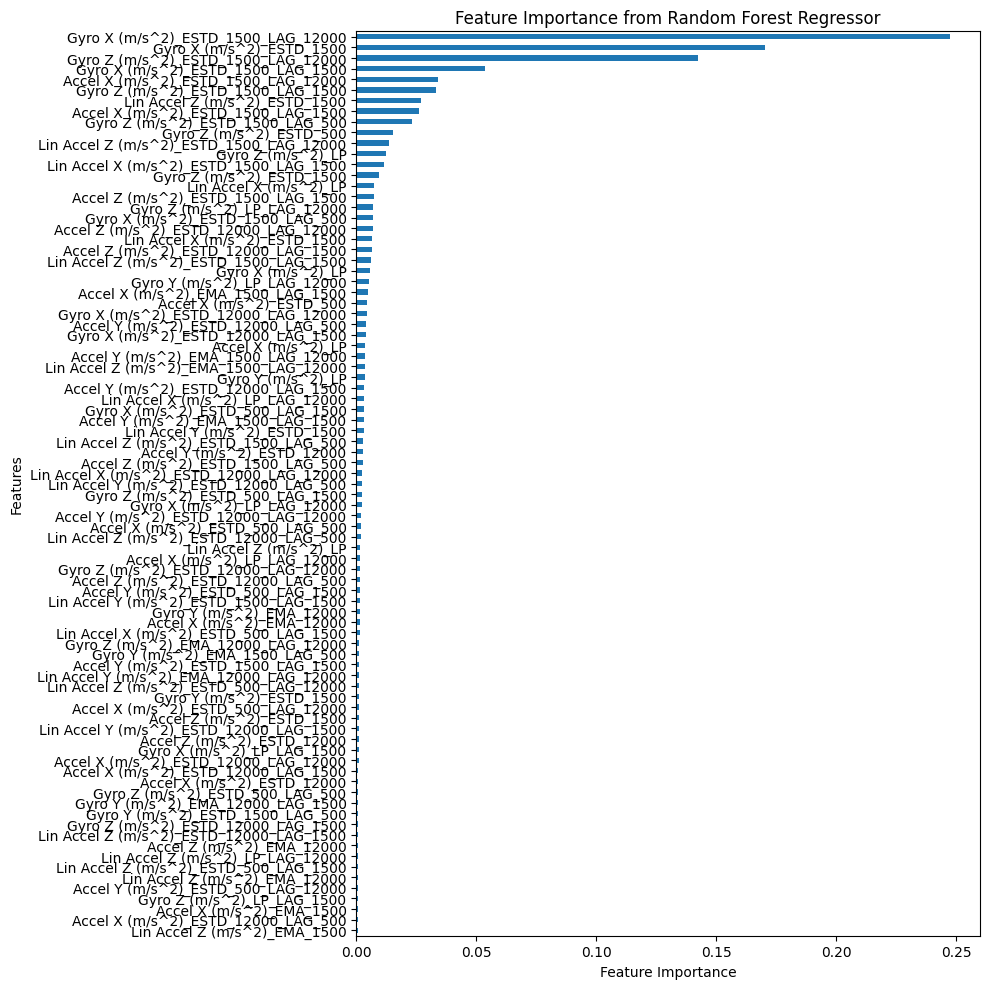

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# get RF best config from the 
best_rf_config = estimator_performance_df.loc['rf', 'best_config'].copy()
best_rf_config['max_leaf_nodes'] = best_rf_config['max_leaves']
best_rf_config.pop('max_leaves')

# Assuming X_train and y_train are already defined
model = RandomForestRegressor(n_jobs=-1, **best_rf_config).fit(X_train, y_train)
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Filter out non-negative values
non_negative_feature_importance = feature_importance[feature_importance >= 10**-8]

# Plotting the feature importances
plt.figure(figsize=(10, 10))
non_negative_feature_importance.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest Regressor')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.tight_layout()
plt.show()